In [1]:
# Install libraries
!pip install kaggle --quiet

# Kaggle setup
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d aishwaryatechie/usd-bill-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/aishwaryatechie/usd-bill-classification-dataset
License(s): MIT
usd-bill-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Import Python libraries for data handling and visualization
import zipfile, random
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Define image transformations (data augmentation to improve generalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),  # Random color changes
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with ImageNet means
                         [0.229, 0.224, 0.225])
])

# Custom Dataset class to read images directly from ZIP file
class BanknoteZipDataset(torch.utils.data.Dataset):
    def __init__(self, zip_path, transform=None):
        self.transform = transform
        self.data = []  # Store file paths and labels
        self.labels = {}  # Map class names to integers

        with zipfile.ZipFile(zip_path, 'r') as archive:
            for file in archive.namelist():
                # Only include valid image files inside the correct folder
                if file.endswith(('.png', '.jpg', '.jpeg')) and 'USA currency' in file:
                    parts = file.split('/')
                    if len(parts) >= 3:
                        label = parts[1]
                        # Skip invalid class folder 'Test Set'
                        if label == 'Test Set':
                            continue
                        # Fix spelling error in class name
                        if label == '2 Doolar':
                            label = '2 Dollar'
                        # Assign integer index to each label
                        if label not in self.labels:
                            self.labels[label] = len(self.labels)
                        self.data.append((file, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file, label = self.data[idx]
        with zipfile.ZipFile('/content/usd-bill-classification-dataset.zip', 'r') as archive:
            image = Image.open(BytesIO(archive.read(file))).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[label]

In [4]:
# Load the dataset
dataset = BanknoteZipDataset('/content/usd-bill-classification-dataset.zip', transform=transform)

# Split dataset: 70% training, 15% validation, 15% testing
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batch processing
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

print(f'Total images: {len(dataset)} | Train: {train_size} | Val: {val_size} | Test: {test_size}')
print(f'Classes: {dataset.labels}')

Total images: 3906 | Train: 2734 | Val: 585 | Test: 587
Classes: {'1 Dollar': 0, '10 Dollar': 1, '100 Dollar': 2, '2 Dollar': 3, '5 Dollar': 4, '50 Dollar': 5}


In [5]:
# Define the CNN model

class DenominationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = DenominationModel(num_classes=len(dataset.labels)).to(device)

# Define training function
def train(model, train_loader, val_loader, epochs=30, patience=20):
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer
    criterion = nn.CrossEntropyLoss()  # Loss function
    best_loss, trigger = float('inf'), 0  # For early stopping
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        train_epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_running_loss += criterion(outputs, labels).item() * images.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)

        print(f'Epoch {epoch+1}: Train Loss = {train_epoch_loss:.4f} | Val Loss = {val_epoch_loss:.4f}')

        # Early stopping logic
        if val_epoch_loss < best_loss:
            best_loss, trigger = val_epoch_loss, 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            trigger += 1
            if trigger >= patience:
                print('Early stopping triggered!')
                break

    return train_loss, val_loss

# Train the model
train_loss, val_loss = train(model, train_loader, val_loader, epochs=30, patience=20)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


Epoch 1: Train Loss = 0.1641 | Val Loss = 0.0768
Epoch 2: Train Loss = 0.0533 | Val Loss = 1.6884
Epoch 3: Train Loss = 0.0535 | Val Loss = 0.0290
Epoch 4: Train Loss = 0.0495 | Val Loss = 0.0288
Epoch 5: Train Loss = 0.0207 | Val Loss = 0.0235
Epoch 6: Train Loss = 0.0153 | Val Loss = 0.0333
Epoch 7: Train Loss = 0.0051 | Val Loss = 0.0259
Epoch 8: Train Loss = 0.0089 | Val Loss = 0.0339
Epoch 9: Train Loss = 0.0149 | Val Loss = 0.0386
Epoch 10: Train Loss = 0.0041 | Val Loss = 0.0761
Epoch 11: Train Loss = 0.0008 | Val Loss = 0.0249
Epoch 12: Train Loss = 0.0118 | Val Loss = 0.0627
Epoch 13: Train Loss = 0.0221 | Val Loss = 0.0371
Epoch 14: Train Loss = 0.0263 | Val Loss = 0.5426
Epoch 15: Train Loss = 0.0343 | Val Loss = 0.0489
Epoch 16: Train Loss = 0.0125 | Val Loss = 0.0110
Epoch 17: Train Loss = 0.0119 | Val Loss = 0.0165
Epoch 18: Train Loss = 0.0225 | Val Loss = 0.0301
Epoch 19: Train Loss = 0.0037 | Val Loss = 0.0128
Epoch 20: Train Loss = 0.0006 | Val Loss = 0.0172
Epoch 21:

In [6]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds, all_labels = [], []

# Predict on the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Print classification report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       104
           1       0.99      1.00      1.00       118
           2       1.00      0.99      0.99        79
           3       0.98      0.99      0.98        92
           4       1.00      0.99      0.99        86
           5       0.99      1.00      1.00       108

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587



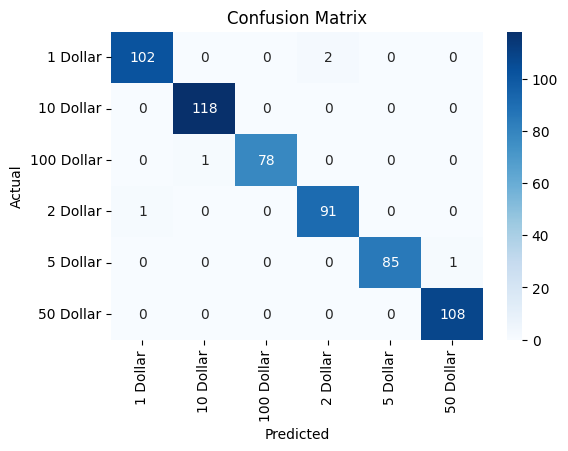

In [7]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d',
            xticklabels=dataset.labels.keys(),
            yticklabels=dataset.labels.keys(), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

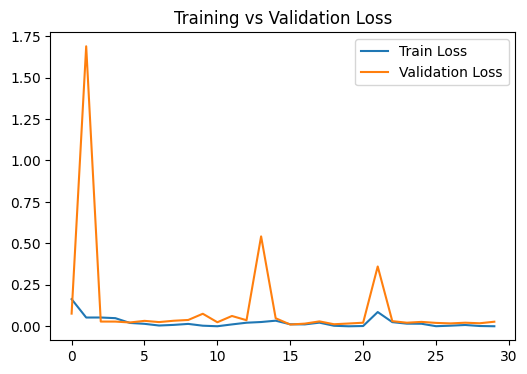

In [8]:
# Plot training and validation loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

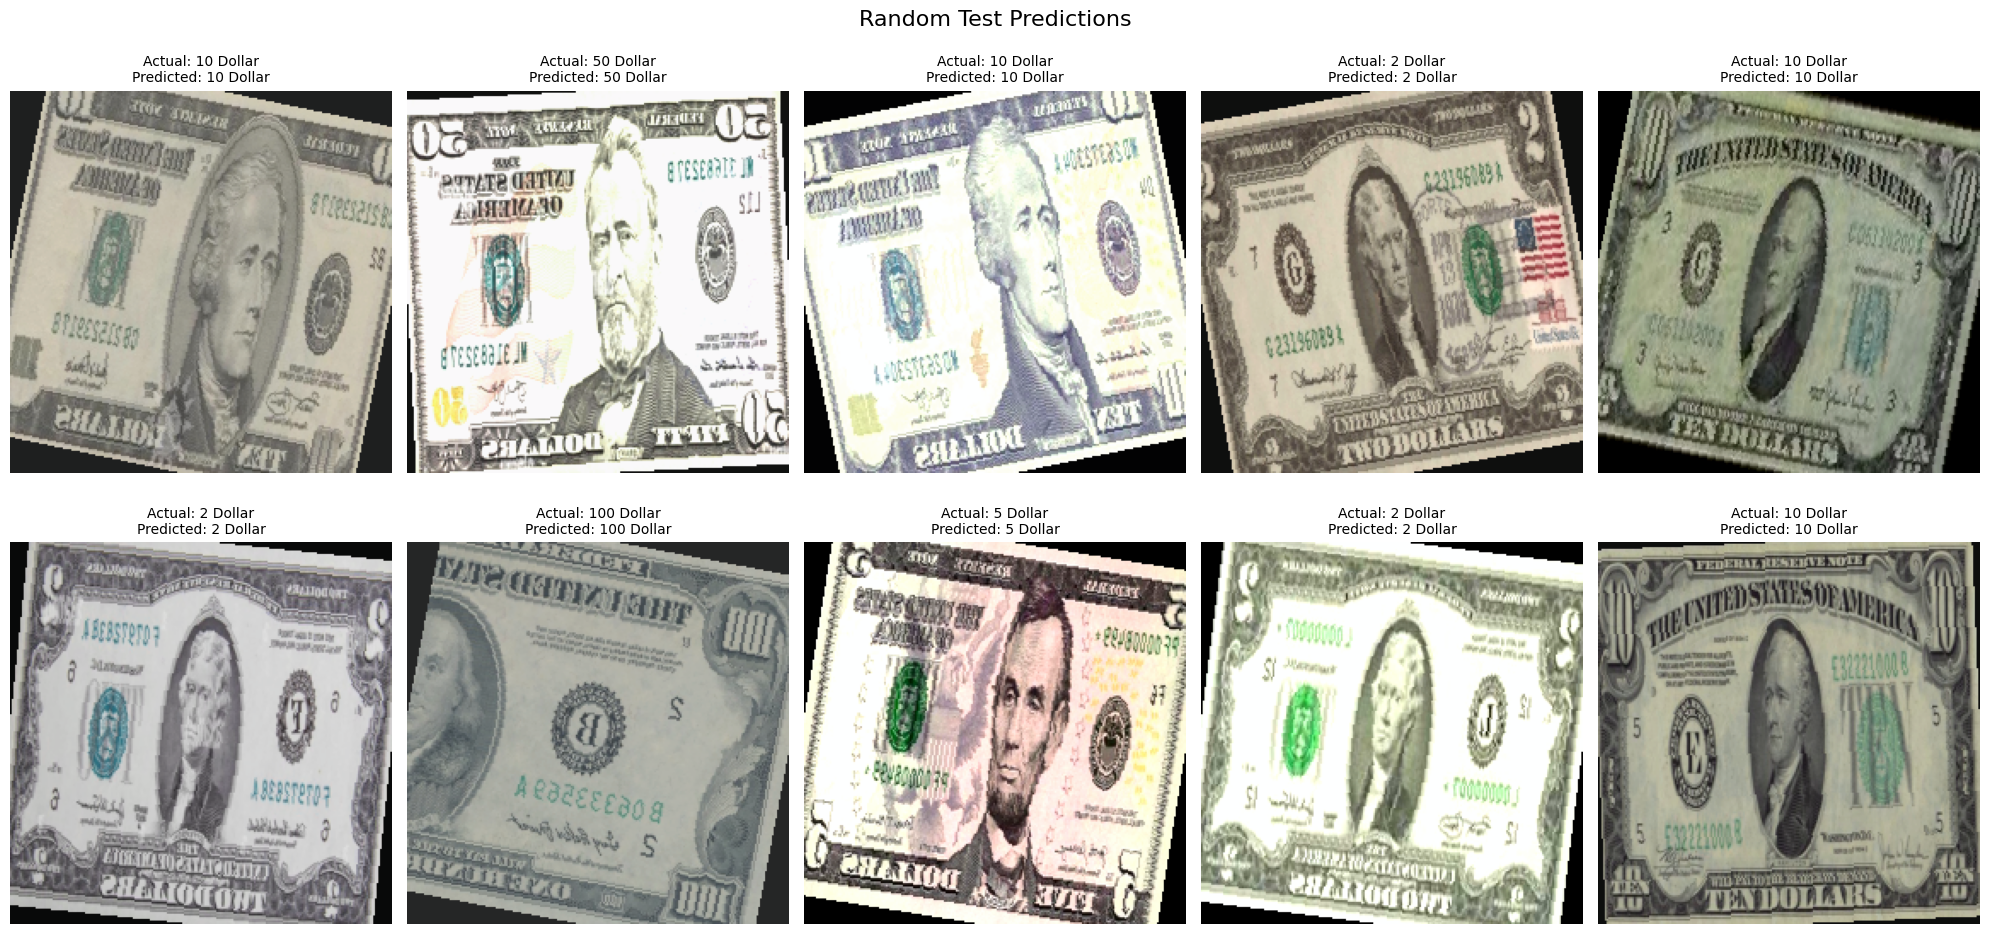

In [9]:
# Map class indices back to labels
labels_map = {v: k for k, v in dataset.labels.items()}
samples = random.sample(range(len(test_set)), 10)

plt.figure(figsize=(20, 10))
for idx, sample_idx in enumerate(samples):
    image, label = test_set[sample_idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted = torch.argmax(output, 1).item()

    # Unnormalize image for display
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Actual: {labels_map[label]}\nPredicted: {labels_map[predicted]}', fontsize=10)

plt.suptitle('Random Test Predictions', fontsize=16)
plt.tight_layout()
plt.show()

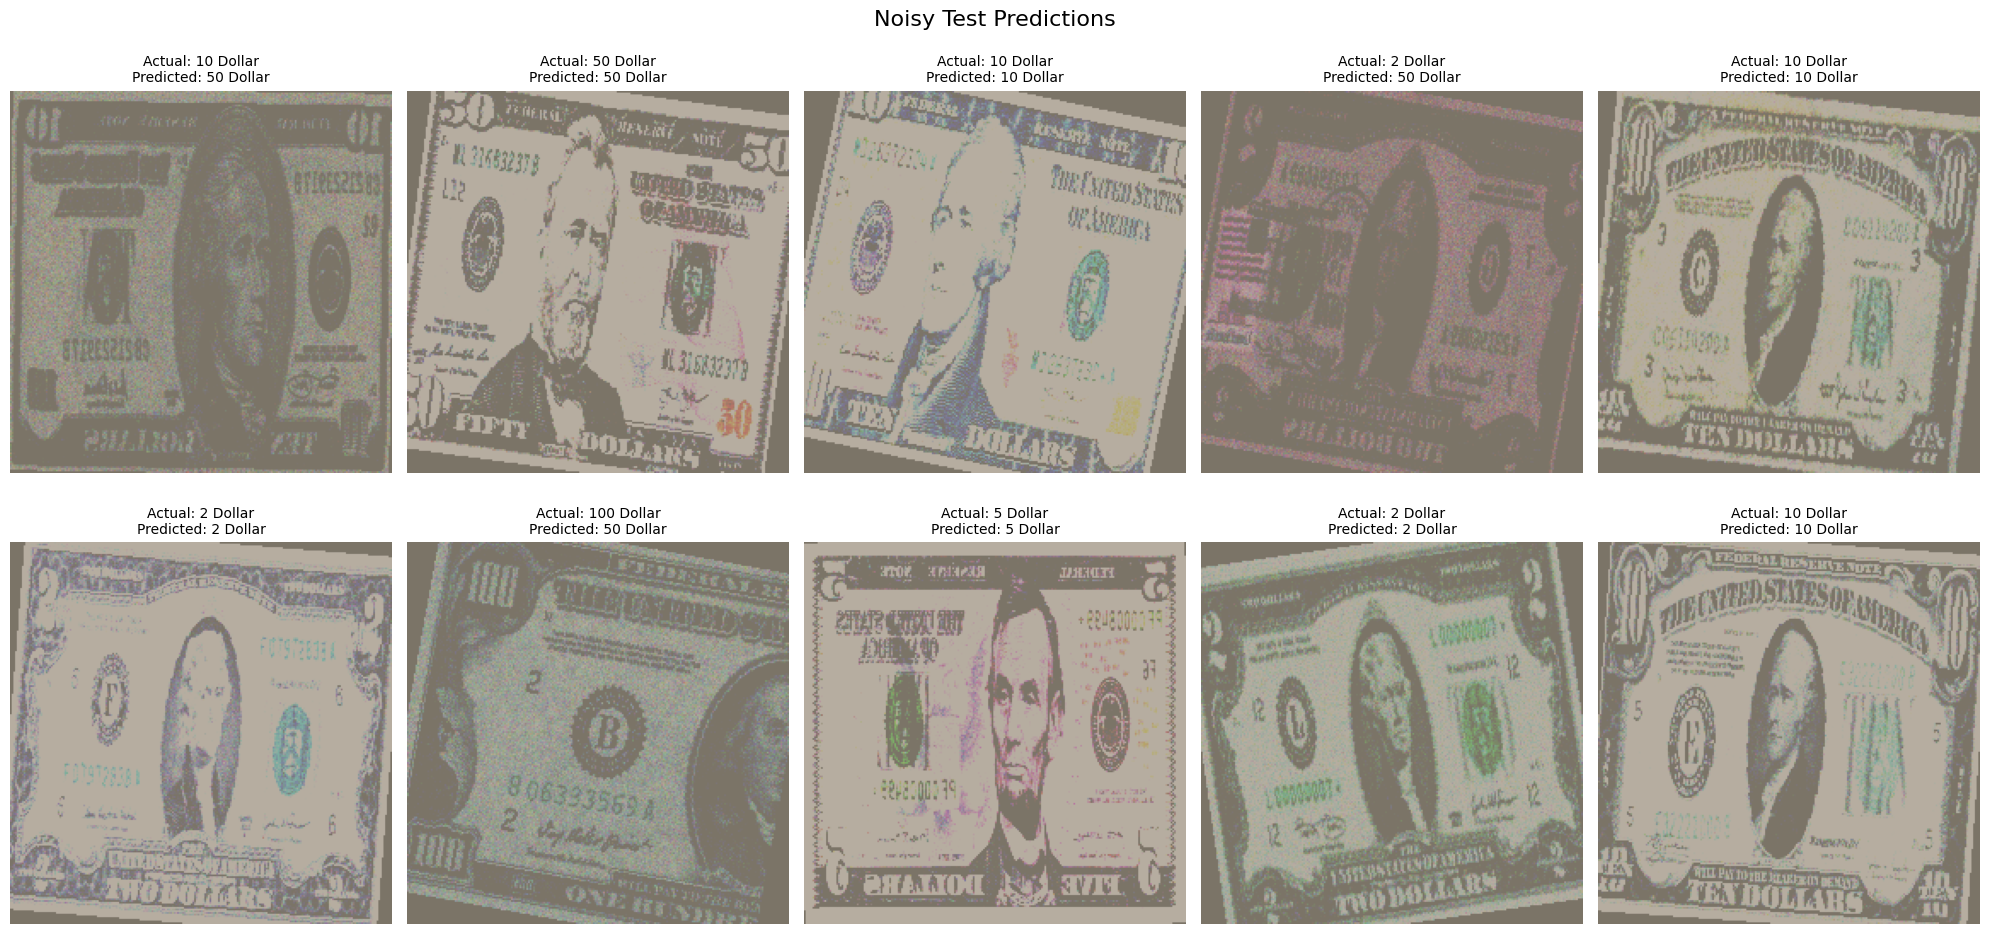

In [10]:
# Function to add random noise to images
def add_noise(image):
    noise = torch.randn_like(image) * 0.2  # noise level
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)  # Keep pixel values between 0 and 1

plt.figure(figsize=(20, 10))
for idx, sample_idx in enumerate(samples):
    image, label = test_set[sample_idx]
    noisy_image = add_noise(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(noisy_image)
        predicted = torch.argmax(output, 1).item()

    # Unnormalize noisy image for display
    image_np = noisy_image.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Actual: {labels_map[label]}\nPredicted: {labels_map[predicted]}', fontsize=10)

plt.suptitle('Noisy Test Predictions', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# Calculate class-wise accuracy
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for true, pred in zip(all_labels, all_preds):
    total_per_class[true] += 1
    if true == pred:
        correct_per_class[true] += 1

print("Class-wise Accuracy:")
for class_idx, total in total_per_class.items():
    accuracy = correct_per_class[class_idx] / total * 100
    class_name = labels_map[class_idx]
    print(f"{class_name}: {accuracy:.2f}%")

Class-wise Accuracy:
1 Dollar: 98.08%
50 Dollar: 100.00%
10 Dollar: 100.00%
5 Dollar: 98.84%
2 Dollar: 98.91%
100 Dollar: 98.73%


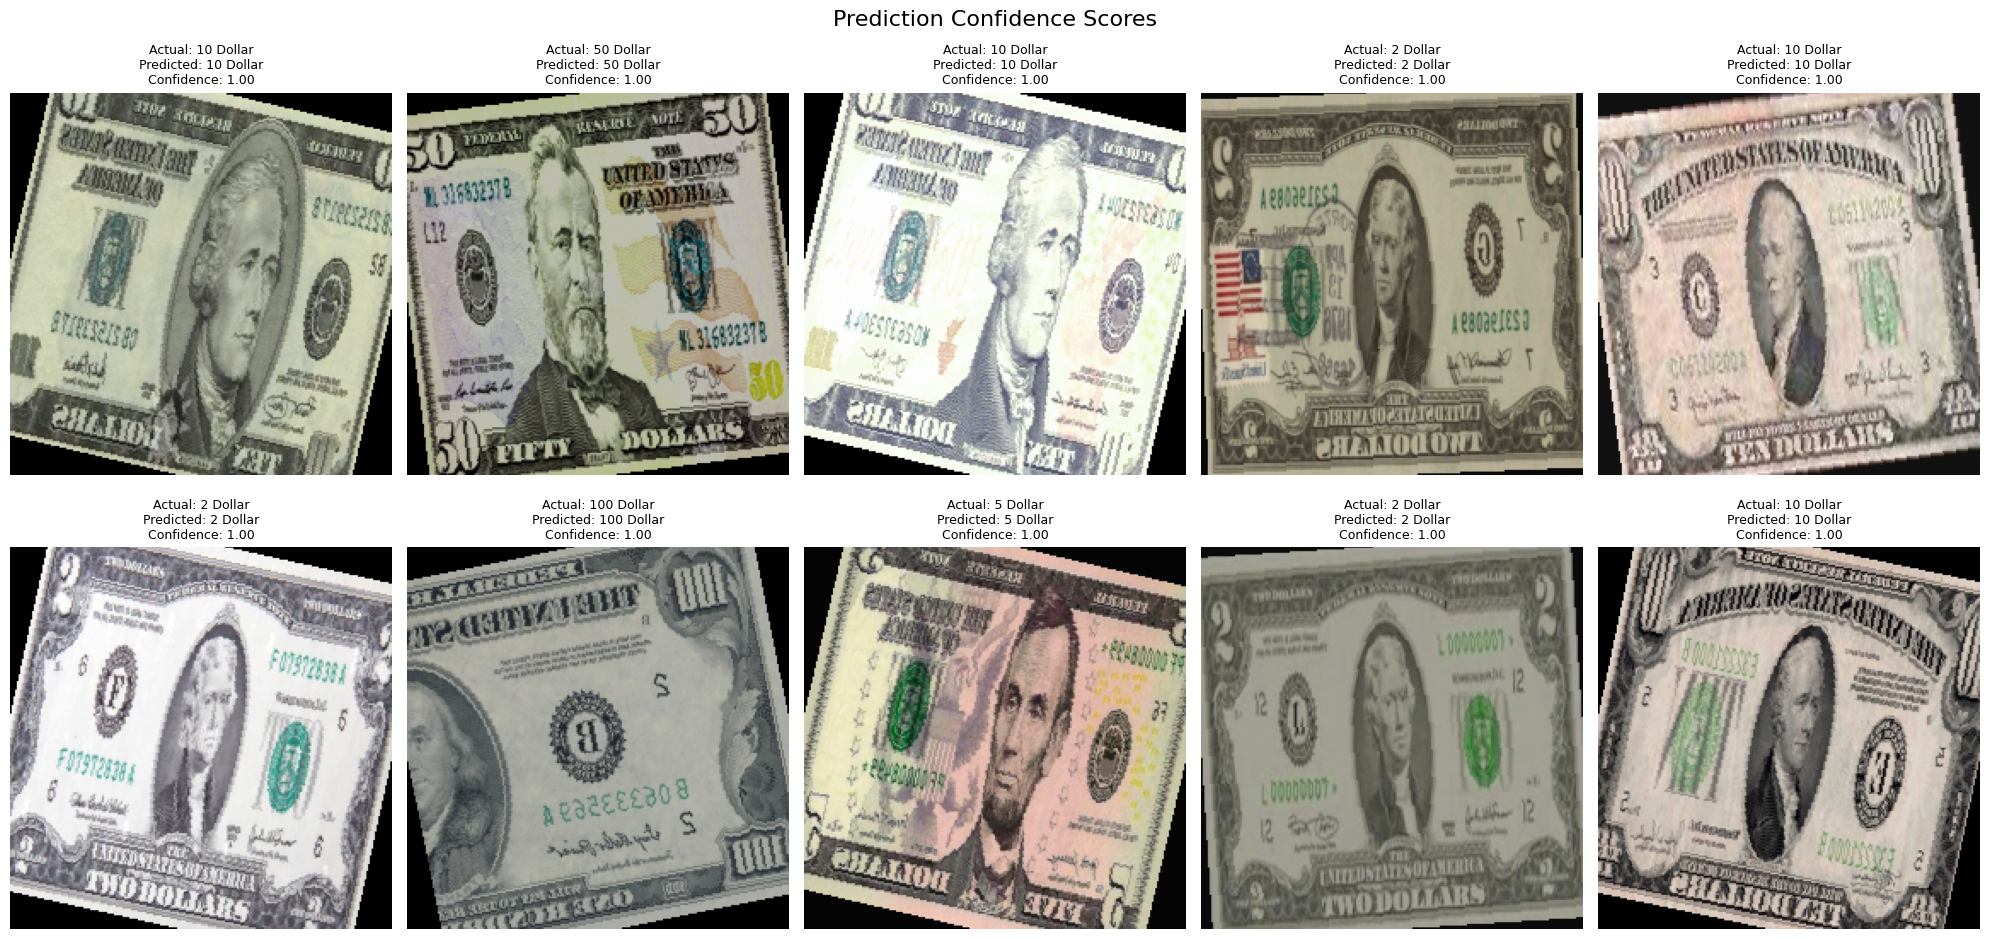

In [13]:
# Show prediction confidence scores for random test images
plt.figure(figsize=(20, 10))
for idx, sample_idx in enumerate(samples):
    image, label = test_set[sample_idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy().flatten()
        predicted = torch.argmax(output, 1).item()

    # Unnormalize image
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f'Actual: {labels_map[label]}\nPredicted: {labels_map[predicted]}\nConfidence: {probs[predicted]:.2f}', fontsize=9)

plt.suptitle('Prediction Confidence Scores', fontsize=16)
plt.tight_layout()
plt.show()